# Конфигурация

In [1]:
# Ячейка нужна для конфигурации сессии при работе с GPU

import tensorflow as tf

# Получить список доступных GPU
physical_devices = tf.config.list_physical_devices('GPU')

# Видеопамять используется по мере необходимости
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Тут указаны все используемые мной константы

In [2]:
# Параметры семантической маски
OIL_ID = 0
EMULSION_ID = 1
WATER_ID = 2

# Параметры изображений
NUM_CLASSES = 3
IMAGE_SIZE = (224, 224)

# 1. Создание модели

## 1.1 Создание Encoder-части

In [3]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model

# Обученная модель, которую мы берем за основу
# input_shape = (ширина изображения, высота изображения, число каналов (для этой модели строго 3))
# include_top = False означает, что мы не берем слой классификатора этой модели
base_model = MobileNetV2(input_shape=[*IMAGE_SIZE, 3], include_top=False, alpha=0.35)

# Выбираем необходимые выходы из модели (TODO: проверить почему именно так)
encoder_output_layer_names = [
    'block_1_expand_relu',  # 64x64
    'block_3_expand_relu',  # 32x32
    'block_6_expand_relu',  # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',  # 4x4
]

output_layers = [base_model.get_layer(name).output for name in encoder_output_layer_names]

# Собираем часть, отвечающую за encoder
encoder = Model(inputs=base_model.input, outputs=output_layers)
# Фиксируем веса, чтобы не изменить их в процессе обучения
encoder.trainable = False

## 1.2 Создание Decoder-части

In [4]:
from tensorflow.keras.metrics import MeanIoU

print(f'Tensorflow verison: {tf.__version__}')

class UpdatedMeanIoU(MeanIoU):
    """
    По какой-то причине, на Tensorflow 2.3.1 при использовании MeanIoU возникает ошибка.
    
    На форуме советуют внести в класс изменения. 
    Ссылка: https://github.com/tensorflow/tensorflow/issues/32875
    
    """
    def __init__(self,
                 y_true=None,
                 y_pred=None,
                 num_classes=None,
                 name=None,
                 dtype=None):
        super(UpdatedMeanIoU, self).__init__(num_classes = num_classes,name=name, dtype=dtype)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.math.argmax(y_pred, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)

Tensorflow verison: 2.3.1


In [5]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import BatchNormalization, Concatenate, Conv2DTranspose, Dropout, Input, ReLU, Softmax
from tensorflow.keras.layers.experimental.preprocessing import Rescaling, Resizing
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam


def image_preprocessor(height: int, width: int) -> Sequential:
    """
    Слой предобработки входных изображений.
    Позволяет отказаться от предобработки входных данных на этапах обучения и использования модели.

    Выполняет следующие операции:
        1. Приводит разрешение входных изображений к заданному.
        2. Нормализует значения пикселов входных изображений к диапазону [0, 1].

    Args:
        image_size (Tuple[int, int]): Желаемое разрешение изображений

    Returns:
        (Sequential): Слой предобработки изображений

    """
    preprocessor = Sequential(name='image_preprocessor')
    preprocessor.add(Resizing(height, width))
    preprocessor.add(Rescaling(1. / 255))
    return preprocessor


def deconvolutional_layer(filters, size, apply_dropout=False):
    """
    Слой обратной свертки.

    Args:
        filters (int): Число фильтров
        size (int): Размер фильтра
        apply_dropout (bool): Флаг применения слоя Dropout

    Returns:
        (tf.keras.Sequential): Слой обратной сверки

    """
    initializer = tf.random_normal_initializer(0., 0.02)
    result = Sequential()
    result.add(Conv2DTranspose(
        filters,
        size,
        strides=2,
        padding='same',
        kernel_initializer=initializer,
        use_bias=False,
        )
    )
    result.add(BatchNormalization())
    if apply_dropout:
        result.add(Dropout(0.5))
    result.add(ReLU())
    return result


# Модель принимает на вход RGB-изображения любого размера
inputs = Input(shape=[None, None, 3])

preprocessed_input = image_preprocessor(*IMAGE_SIZE)(inputs)

# Переиспользуем обученные слои
encoder_outputs = encoder(preprocessed_input)

# Получаем промежуточное представление данных
skip_connections = reversed(encoder_outputs[:-1])

# Получаем итоговое скрытое представление данных
feature_vector = encoder_outputs[-1]

# Созадем upsampling-слои, чтобы восстановить изображение маски
deconv_stack = [
    deconvolutional_layer(512, 3),  # 4x4 -> 8x8
    deconvolutional_layer(256, 3),  # 8x8 -> 16x16
    deconvolutional_layer(128, 3),  # 16x16 -> 32x32
    deconvolutional_layer(64, 3),  # 32x32 -> 64x64
]

# Восстанавливаем изображение с использованием skip-connections
for deconv, skip in zip(deconv_stack, skip_connections):
    feature_vector = deconv(feature_vector)
    concat = Concatenate()
    feature_vector = concat([feature_vector, skip])

# Слой, формирующий итоговую маску изображения 
output_layer = Conv2DTranspose(
    filters=NUM_CLASSES, 
    kernel_size=3,
    strides=2,
    padding='same'
)(feature_vector)  # 64x64 -> 128x128

outputs = Softmax()(output_layer)

model = Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer=Adam(lr=0.001),
    loss=SparseCategoricalCrossentropy(from_logits=False),
    metrics=[UpdatedMeanIoU(num_classes=NUM_CLASSES, name='mean_iou'), ])

# 2. Создание генератора данных

In [9]:
import numpy as np
import cv2 as cv
from keras.preprocessing.image import ImageDataGenerator

X = np.load(r'images.npy')
y = np.load(r'masks.npy')

X = np.delete(X, [173, 237, 260], axis=0)
y = np.delete(y, [173, 237, 260], axis=0)

# shapes = np.array([np.unique(mask).shape[0] for mask in y])
# idx = shapes==3
# X = X[idx]
# y = y[idx]

# to_sort = []
# for mask in y:
#     uniques, counts = np.unique(mask, return_counts=True)
#     counts = counts[uniques==0]
#     to_sort.append(counts)
# to_sort = [x[0] for x in to_sort]
# idx = np.argsort(to_sort)
# X = X[idx][130:]
# y = y[idx][130:]


X = X / 255.
# y = y / 2.

X = np.array([cv.resize(image, IMAGE_SIZE, interpolation=cv.INTER_NEAREST) for image in X])
y = np.array([cv.resize(image, IMAGE_SIZE, interpolation=cv.INTER_NEAREST) for image in y])
y = np.expand_dims(y, axis=-1)

print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')

print(f'y uniques: {np.unique(y)}')

print(f'X dtype: {X.dtype}')
print(f'y dtype: {y.dtype}')

SEED = 1223

COMMON_DATAGEN_PARAMS = {
        'rotation_range': 15,
        'width_shift_range': 0.2,
        'height_shift_range': 0.2,
        'zoom_range': 0.2,
        'validation_split': 0.2,
#         'horizontal_flip': True,
#         'vertical_flip': True,
        'fill_mode': 'reflect',
}


FLOW_PARAMS = {
        'batch_size': 64,
        'shuffle': True,
        'seed': SEED,
}

X_datagen = ImageDataGenerator(**COMMON_DATAGEN_PARAMS)  # , brightness_range=(0.8, 1.2)
X_datagen.fit(X)

y_datagen = ImageDataGenerator(**COMMON_DATAGEN_PARAMS)

train_generator = zip(
    X_datagen.flow(X, **FLOW_PARAMS, subset='training'),
    y_datagen.flow(y, **FLOW_PARAMS, subset='training')
)

validation_generator = zip(
    X_datagen.flow(X, **FLOW_PARAMS, subset='validation'),
    y_datagen.flow(y, **FLOW_PARAMS, subset='validation')
)

X shape: (760, 224, 224, 3)
y shape: (760, 224, 224, 1)
y uniques: [0. 1. 2.]
X dtype: float64
y dtype: float64


In [10]:
# import matplotlib.pyplot as plt
# import cv2 as cv
# fix, axes = plt.subplots(21, 10, figsize=(20,44))
# i = 0
# for row in axes:
#     for col in row:
#         col.imshow(cv.cvtColor(y[i].astype('uint8') * 100, cv.COLOR_GRAY2RGB))
#         i += 1

# 3. Обучение модели

In [8]:
from tensorflow.keras.callbacks import ReduceLROnPlateau


model_history = model.fit(
    x=train_generator,
    validation_data=validation_generator,
    steps_per_epoch=20,
    epochs=20,
    verbose=1,
    validation_steps=10,
#     callbacks=[ReduceLROnPlateau(monitor='val_mean_iou', min_delta=0.001, factor=0.5), ]
)

Epoch 1/20
20/20 [==============================] - ETA: 0s - loss: 0.8473 - mean_iou: 0.2788

KeyboardInterrupt: 

Text(0.5, 1.0, 'Динамика метрики')

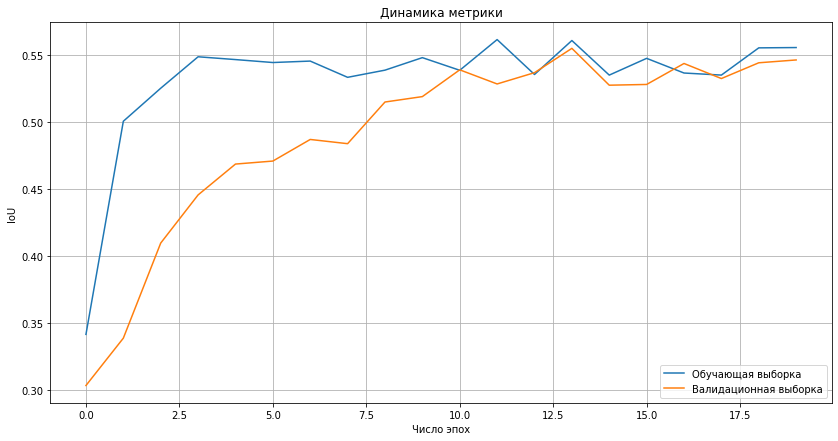

In [38]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, figsize=(14,7))
ax.plot(model_history.history['mean_iou'], label='Обучающая выборка')
ax.plot(model_history.history['val_mean_iou'], label='Валидационная выборка')
ax.legend()
ax.grid()
ax.set_xlabel('Число эпох')
ax.set_ylabel('IoU')
ax.set_title("Динамика метрики")

# 4. Использование модели

In [11]:
from typing import List

import matplotlib.pyplot as plt

def display_comparison(images: List[np.ndarray]):
    """
    Функция отображения исходного изображения, истинной маски и предсказанной маски.
    
    Args:
        images (List[np.ndarray]): Список из изображения, истинной маски и предсказанной маски
        
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    titles = ['Input Image', 'True Mask', 'Predicted Mask']

    for ax, image, title in zip(axes, images, titles):
        ax.imshow(image)
        ax.set_title(title)
        ax.axis('off')

In [12]:
def create_mask(prediction: np.ndarray) -> np.ndarray:
    """
    Функция создания маски изображений из предсказания модели.
    
    Args:
        prediction (np.ndarray): Предсказание модели

    Returns:
        mask (np.ndarray): Маска изображения
        
    """
    # Выбрать наиболее вероятные классы для пикселей
    mask = np.argmax(prediction, axis=-1)
    # Добавить ось каналов
    mask = np.expand_dims(mask, axis=-1)
    return mask

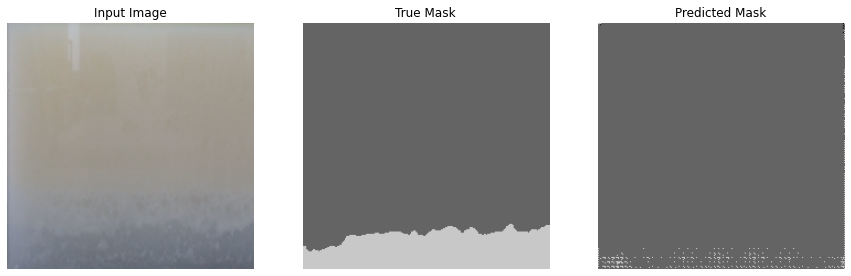

In [16]:
INDEX = np.random.choice(X.shape[0])

prediction = model.predict(X[INDEX:INDEX + 1])[0]

image = X[INDEX]
true_mask = y[INDEX]
predicted_mask = create_mask(prediction)

display_comparison([image, 
                    cv.cvtColor(true_mask.astype('uint8') * 100, cv.COLOR_GRAY2RGB), 
                    cv.cvtColor(predicted_mask.astype('uint8') * 100, cv.COLOR_GRAY2RGB)])

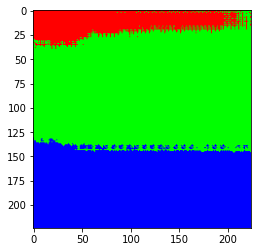

In [37]:
water_mask = np.zeros_like(predicted_mask).astype('uint8')
water_mask[predicted_mask == 2] = 255

emulsion_mask = np.zeros_like(predicted_mask).astype('uint8')
emulsion_mask[predicted_mask == 1] = 255

oil_mask = np.zeros_like(predicted_mask).astype('uint8')
oil_mask[predicted_mask == 0] = 255

rgb_mask = np.dstack([oil_mask, emulsion_mask, water_mask])
plt.imshow(rgb_mask)

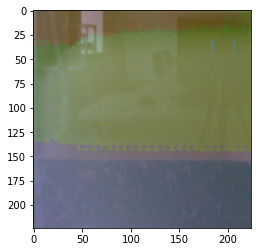

In [14]:
import cv2 as cv
plt.imshow(cv.addWeighted((image * 255).astype('uint8'), 0.91, rgb_mask, 0.09, 0.0))

In [15]:
cv.resize((image * 255).astype('uint8'), (224,224), cv.INTER_LINEAR).dtype

dtype('uint8')

In [16]:
MeanIoU(3)(true_mask, predicted_mask)

<tf.Tensor: shape=(), dtype=float32, numpy=0.81194305>

In [17]:
import os
import time

def show(directory):
    entries = list(os.scandir(directory))
    img_paths = [entry.path for entry in entries if entry.is_file()]
    # Какая-то кривая сортировка названий
    img_names = [int(entry.name.split('.')[0][5:]) for entry in entries if entry.is_file()]
    img_paths = np.array(img_paths)[np.argsort(img_names)]
    
    for img_path in img_paths:
        img = cv.imread(img_path) / 255.
        prediction = model.predict(np.expand_dims(img, axis=0))[0]
        predicted_mask = create_mask(prediction)
        predicted_mask = (predicted_mask * 100).astype('uint8')
        cv.imshow('Mask', predicted_mask)
        cv.imshow('Image', cv.resize(img * 255, IMAGE_SIZE).astype('uint8'))
        if cv.waitKey(25) & 0xFF == ord('q'):
            break
#         time.sleep(0.2)
    cv.destroyAllWindows()

In [18]:
show(r'C:\Users\zvfrf\Desktop\frames')

In [19]:
cv.destroyAllWindows()